## Import Libraries
### Import Python and SDR Libraries

In [1]:
%matplotlib widget

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import sionna as sn
import adi
import matplotlib.pyplot as plt


### Import 5G Toolkit Libraries 

In [14]:
import sys
sys.path.append("../../../../")

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.PhysicalChannels   import PBCHDecoder
from toolkit5G.OFDM               import OFDMDemodulator
from carrierFrequencyOffestEstimation import CarrierFrequencyOffestEstimation

## Emulation Configurations

In [15]:
# System Parameters
center_frequency    = 1000e6 # Hz

# OFDM Parameters
Bandwidth           = 10*10**6
fftSize             = 1024
subcarrier_spacing  = 30000
numOFDMSymbols      = 14
sample_rate         = fftSize*subcarrier_spacing

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)

## PBCH Payload Generation: MIB + ATI

In [16]:
nSymbolFrame= 140*int(subcarrier_spacing/15000);   # Number of OFDM symbols per frame (Its a function of subcarrier spacing)

## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing, fftsize = fftSize)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff          # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
fftsize     = tfParams.fftsize       # FFT-size for OFDM
lengthCP    = tfParams.lengthCP      # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, ssbSubCarrierOffset = 0)

systemFrameNumber               = ssbParameters.systemFrameNumber 
subCarrierSpacingCommon         = ssbParameters.subCarrierSpacingCommon 
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset #ssbParameters.ssbSubCarrierOffset 
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition 
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset 
choiceBit                       = ssbParameters.choiceBit 
ssbType                         = ssbParameters.ssbType 
nssbCandidatesInHrf             = 4     #ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit 
cellBarred                      = ssbParameters.cellBarred 
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection 
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

nFrames                         = 0.5
Nsc_ssb                         = 240   # Numbers of subcarrier in SSB
Nsymb_ssb                       = 4     # Numbers of OFDM symbols in SSB

## PSS, SSS, PBCH, DMRS Generation

In [17]:
N_ID2        = np.random.randint(3)   # N_ID2 can take values of 0,1 and 2.

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()   # PSS sequence

N_ID1        = np.random.randint(336) # N_ID1 can take values ranging from 0 to 335.
N_ID         = 3*N_ID1 + N_ID2        # Calculating Physical Cell ID.

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2)
sssSequence  = sssObject()      # SSS Sequence

# Generate DMRS sequence
dmrsLen      = 144                    # length of DMRS sequence.   
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
dmrsSequence = dmrsObject(dmrsLen)    # DMRS sequence


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()           # PBCH payload symbol (QPSK modulated)

## Constellation Diagram: Base Station

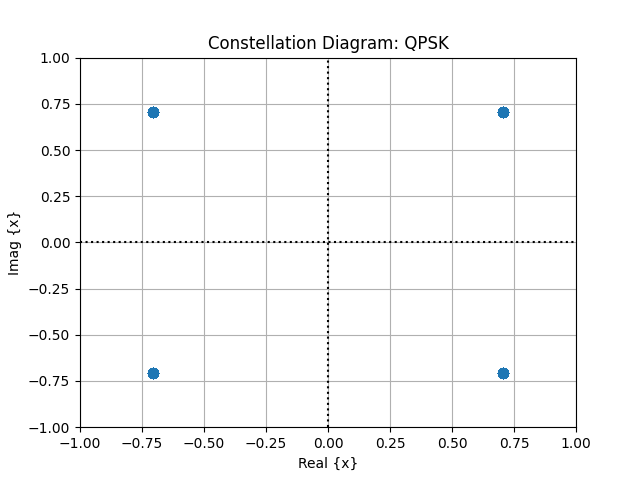

In [18]:
fig, ax = plt.subplots()
ax.scatter(np.real(pbchSymbols),  np.imag(pbchSymbols), s=48)
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

## SSB Generation

In [19]:
## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols) # generating SSB using PSS,SSS, PBCH payload and DMRS.   

## Loading SSB to Resource Grid

ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1 

ssbRGobject    = ResourceMapperSSB(ssbType, center_frequency, isPairedBand, withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset,
                      offsetInRBs = 0, numRBs = nRB)[0:14]                  # SSB Grid of size 14 X numbers of RBs x 12.

In [20]:
np.savez("ssbGrid.npz", ssb = ssb)

## OFDM Implementation-- Transmission of SSB.

In [21]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftsize - Neff)/2), int((fftsize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

X = np.zeros((numOFDMSymbols, fftsize), dtype= np.complex64)  # Generating grid of size 14 X  FFT_Size.
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid   # Loading SSB into grid.

### OFDM Modulation at Transmitter
modulator = OFDMModulator(lengthCP[1]) # OFDM modulation
x_time    = modulator(X).flatten()     # Time domain samples from OFDM modulation.

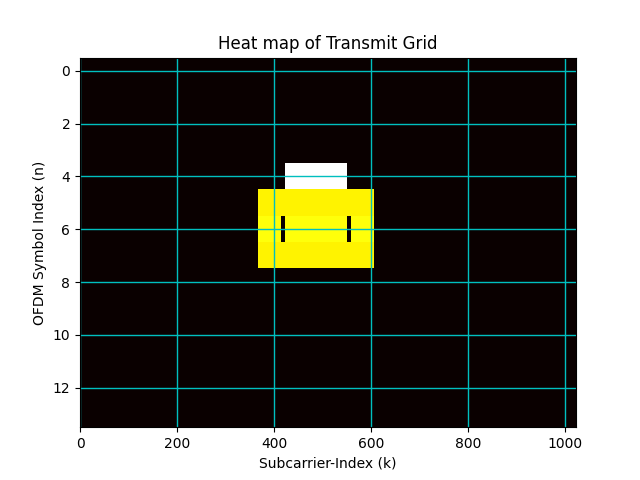

In [22]:
### Plot Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## SDR Setup

In [23]:
# Basic SDR Setup
sdr = adi.Pluto("ip:192.168.3.1")
sdr.sample_rate = int(sample_rate)

# Config Tx
sdr.tx_rf_bandwidth = int(sample_rate) # filter cutoff, just set it to the same as sample rate
sdr.tx_lo           = int(center_frequency)
sdr.tx_hardwaregain_chan0 = 0 # Increase to increase tx power, valid range is -90 to 0 dB

## Transmission

In [24]:
# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers

sdr.tx(1.4*2**17*(x_time.repeat(1))) # start transmitting

## MIB parameters at BS

In [25]:
pbchObject.mib.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		0
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:30000
DMRSTypeAPosition: 	typeB
controlResourceSet0:	4
searchSpace0: 		9
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	286
ssbSubCarrierOffset: 	0
HRFBit: 		1
iSSBindex: 		0


# Receiver

In [26]:
# Config Rx
sdr.gain_control_mode_chan0 = 'slow_attack'
sdr.rx_lo           = int(center_frequency)
sdr.rx_rf_bandwidth = int(60*10**6) # filter width, just set it to the same as sample rate for now

buffer_size         = int(fftSize*4*numSamplesPerSymbol*numOFDMSymbols) 
sdr.rx_buffer_size  = int(buffer_size)

## Receive Samples from SDR

In [27]:
# Receive samples
rx_samples = sdr.rx()

## Time Synchronization: Coarse Tuning

**(rasterOffset, PSS-ID) (368, 0)
**(rasterOffset, PSS-ID) (368, 1)
**(rasterOffset, PSS-ID) (368, 2)


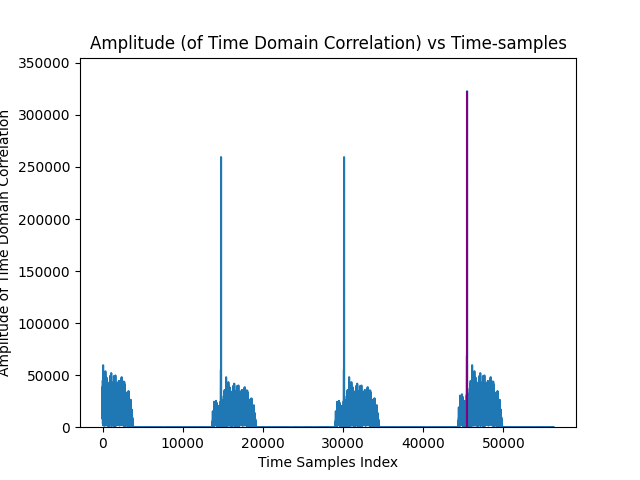

In [28]:
## PSS Detection: Based on time domain PSS Correlation

numofGuardCarriers = (int((tfParams.fftsize - Neff)/2), int((tfParams.fftsize + Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)

## PSS Detection: Based on time domain PSS Correlation
# pssDetection   = PSSDetection("correlation", "threshold")
pssDetection   = PSSDetection("largestPeak")
ssboffset      = int(numofGuardCarriers[0]+offsetToPointA)
pssPeakIndices, pssCorrelation, rN_ID2, freqOffset = pssDetection(rx_samples, fftSize, lengthCP = lengthCP[1],
                                                                  nID2 = None, freqOffset = ssboffset)

## PSS Detection Plot
#################################################################
fig, ax = plt.subplots()

# single line
ax.plot(pssCorrelation)
ax.vlines(x = pssPeakIndices, ymin = 0*pssCorrelation[pssPeakIndices],
           ymax = pssCorrelation[pssPeakIndices], colors = 'purple')
ax.set_ylim([0,np.max(pssCorrelation)*1.1])
ax.set_xlabel("Time Samples Index")
ax.set_ylabel("Amplitude of Time Domain Correlation")
ax.set_title("Amplitude (of Time Domain Correlation) vs Time-samples")
plt.show()

## CFO Estimation

In [29]:

## Parameters for computing CFO
cyclic_prefix_length      = lengthCP[1]  # Length of cyclic prefix
numSamples                = fftSize + cyclic_prefix_length  # OFDM samples of 1 symbol
firstIndex                = pssPeakIndices  # PSS detection
pssOfdmSymbols            = rx_samples[firstIndex: firstIndex + numSamples] # PSS samples

obj = CarrierFrequencyOffestEstimation(fftSize,cyclic_prefix_length)
Cfo = obj(pssOfdmSymbols,numCfoIteration = 2) # Computed CFO

## OFDM Demodulation

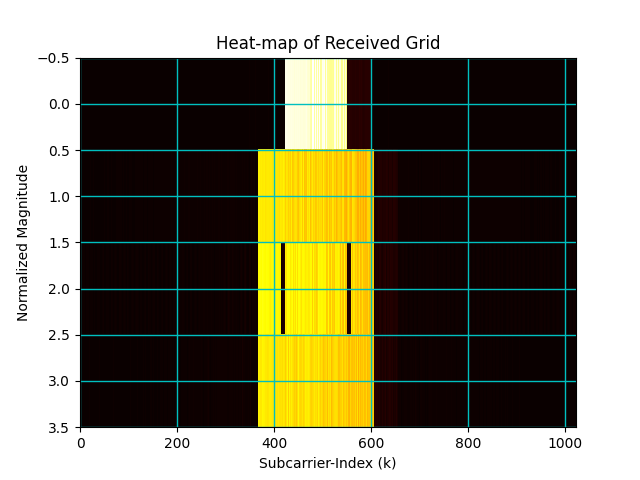

In [30]:
## OFDM Demodulator Object
ofdmDemodulator = OFDMDemodulator(fftSize, lengthCP[1])
pssStartIndex   = pssPeakIndices 
indices         = np.arange(rx_samples.size)

# Without CFO correction
cfo             = 0

# With CFO correction
cfo = Cfo

rxGrid          = ofdmDemodulator(((np.exp(-1j*cfo*indices/fftSize)*rx_samples).reshape(1,-1))[...,pssStartIndex:(pssStartIndex+4*(fftSize+lengthCP[1]))])

ssbEstimate     = rxGrid[:,:,ssboffset:(ssboffset+240)]

# Plot Received Resource Grid
fig, ax = plt.subplots()
plt.imshow(np.abs(rxGrid[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received Grid")
ax.grid(color='c', linestyle='-', linewidth=1)
plt.show()

## Extract SSB Grid

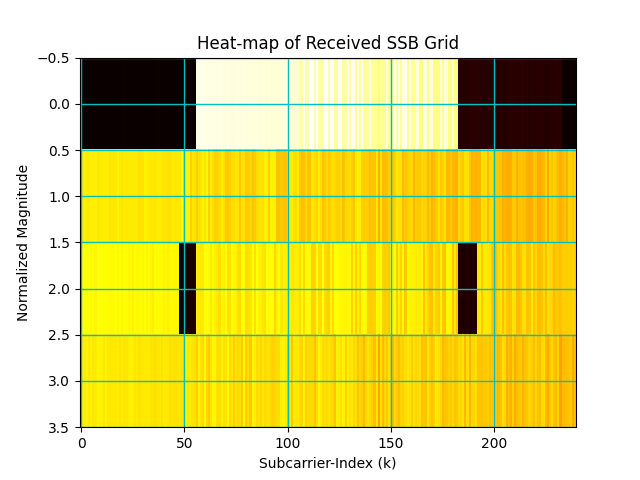

In [31]:
## Plot SSB
fig, ax = plt.subplots()
plt.imshow(np.abs(ssbEstimate[0]), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("Normalized Magnitude")
ax.set_title("Heat-map of Received SSB Grid")
plt.show()

## PBCH Processing

* SSS Detection
* PBCH Parameter Estimation

In [32]:
## N_ID_1 Estimation: SSS based
sssDetection   = SSSDetection(method="channelAssisted", nID2=rN_ID2)
rN_ID1         = sssDetection(ssbEstimate[0])
rN_ID          = 3*rN_ID1 + rN_ID2    # Estimating Physical cell-ID.

## Generate SSB object to get DMRS and PBCH Indices
rxSSBobject    = SSB_Grid(rN_ID)
rxDMRSIndices  = rxSSBobject.dmrsIndices   # Indices of PBCH DMRS.

## Generate DMRS sequence
nssbCandidatesInHrf = 4
dmrsLen             = 144  # Length of DMRS sequence
dmrsDetection  = DMRSParameterDetection(int(rN_ID), nssbCandidatesInHrf)
rssbIndex, rHrfBit = dmrsDetection(ssbEstimate[0])
rxDMRSobject   = DMRS("PBCH", int(rN_ID), int(rssbIndex), nssbCandidatesInHrf, rHrfBit)
rxDMRSseq      = rxDMRSobject(dmrsLen) # DMRS sequence.

## Channel Estimation and PBCH Symbol Equalization

In [33]:
chanEst        = ChannelEstimationAndEqualization(estimatorType = "ZF", interpolatorType = "NN")
rxPBCHIndices  = rxSSBobject.pbchIndices   # Indices of PBCH payload                                         
pbchEstimate   = chanEst(ssbEstimate[0], rxDMRSseq[0], rxDMRSIndices, rxPBCHIndices) # Equalized PBCH symbols.


## PBCH Decoding

In [34]:
## PBCH Chain for Decoding information
polarDecoder   = "SCL"
symbolDemapper = "app"
extractMIBinfo = True
pbchDecoder    = PBCHDecoder(center_frequency, int(rN_ID), nssbCandidatesInHrf, 
                             rssbIndex, polarDecoder, symbolDemapper)
rxMIB, check   = pbchDecoder(pbchEstimate, 10, extractMIBinfo)

C:\Users\Dell\Documents\SDR\Tutorials_new\Emulations\Pluto-SDR\Hardware Emulations\../../../..\toolkit5G\ChannelCoder\PolarCoder\polarDecoder.py:494: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


## Constellation Diagram: UE

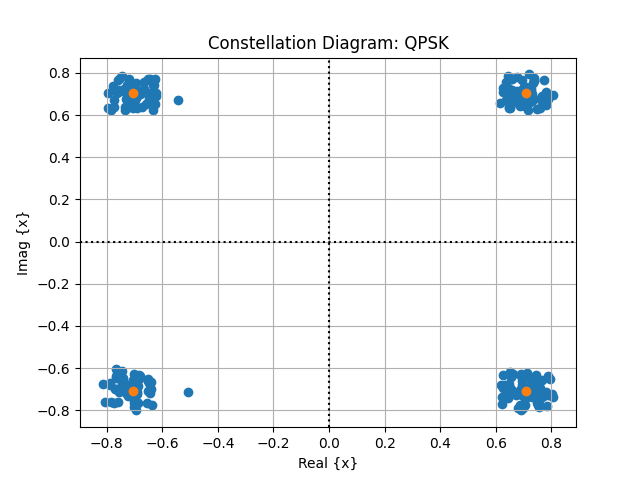

In [35]:
qpsk = np.array([1+1j, 1-1j, -1+1j, -1-1j])/np.sqrt(2)
fig, ax = plt.subplots()
ax.scatter(np.real(pbchEstimate), np.imag(pbchEstimate))
ax.scatter(np.real(qpsk), np.imag(qpsk), )
ax.grid()
ax.axhline(y=0, ls=":", c="k")
ax.axvline(x=0, ls=":", c="k")
# ax.set_xlim([-1, 1])
# ax.set_ylim([-1, 1])
ax.set_xlabel("Real {x}")
ax.set_ylabel("Imag {x}")
ax.set_title("Constellation Diagram: QPSK")
plt.show()

## Checking whether CRC is correct

In [36]:
check

array([[ True]])

## MIB and ATI Parameters at User Equioment

In [37]:
pbchDecoder.mibRx.displayParameters(0)

Carrier Frequency:	1000000000.0
ChoiceBit:  		0
nSsbCandidatesInHrf: 	4
subCarrierSpacingCommon:30000
DMRSTypeAPosition: 	typeB
controlResourceSet0:	4
searchSpace0: 		9
cellBarred: 		barred
intraFreqReselection: 	allowed
systemFrameNumber: 	286
ssbSubCarrierOffset: 	0
HRFBit: 		1
iSSBindex: 		0
